<a href="https://colab.research.google.com/github/dasha-shchep/fssh_colab/blob/master/fssh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing the FSSH algorithm on Tully's example problems
This notebook will go through the basic FSSH algorithm and run parallel trajectories as described in the original paper - Tully, J.C. *J. Chem. Phys.* (1990) **93** 1061 - [here](https://doi.org/10.1063/1.459170).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# !pip install pyscf
# from pyscf import scf

We will limit ourselves at this stage to a two-state model system.
These three types of model potential that Tully described are:

A. Simple avoided crossing (SAX)

B. Dual avoided crossing (DAX)

C. Extended coupling with reflection (ECR)

On the next line we create a SAX potential class:

In [0]:
# Setting up model (1-D potential) classes
# Creating a model class lets us play with more complex model potentials later
class SAXModel:
  """
  First model two-level problem defined by the following interactions in the
  diabatic representstion:
  V11(X) = A[1 - exp(-BX)] for x > 0
  V11(X) = - A[1 - exp(BX)] for x < 0
  V22(X) = - V11(X)
  V21(X) = V12(X) = C exp(-DX**2)
  Default choice of parameters:
  A = 0.01 ; B = 1.6 ; C = 0.005 ; D = 1.0
  """
  _num_states = 2
  _num_dims   = 1
  
  def __init__(self,a=0.01,b=1.6,c=0.005,d=1.0):
    self.A = a
    self.B = b
    self.C = c
    self.D = d

  def V(self,R):
    sign = np.sign(R)
    V11 = sign*self.A*(1 - np.exp(-self.B*sign*R))
    V22 = -V11
    V12 = self.C*np.exp(-self.D*R**2)
    V21 = V12
    return np.array([[V11,V12],[V21,V22]])

  def dV(self,R):
    sign = np.sign(R)
    dV11 = self.A*self.B*np.exp(-self.B*abs(R))
    dV22 = - dV11
    dV12 = self.C*np.exp(-self.D*R**2)
    dV21 = dV12
    return np.array([[dV11,dV12],[dV21,dV22]])

  def diagonalize(self,R):
    self.position = R
    hamiltonian = self.V(R)
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)
    return eigenvalues, eigenvectors

  def d_12(self,R):
    z = (self.V(R)[0,0] - self.V(R)[1,1])/(self.V(R)[0,1]*2e0)
    D12 = - 1/(2*(1+z**2))*((1/(2*self.V(R)[0,1]**2)) * 
          (self.V(R)[0,1]*(self.dV(R)[0,0]-self.dV(R)[1,1])) 
          -self.dV(R)[0,1]*(self.V(R)[0,0]-self.V(R)[1,1]))
    D21 = -D12
    D11 = 0
    D22 = 0
    return np.array([[D11,D12],[D21,D22]])


Nonadiabatic coupling between states 1 and 2 is given by

$d_{12}(R) = \langle\phi_{1}(r;R)|\nabla_{R}\phi_{2}(r;R)\rangle$

where the electronic coordinate $r$ is parametrically dependent on the nuclear coordinate $R$.

In the above class it was analytically derived from eigenvectors of V.

In [688]:
# Instance of SAX class
model = SAXModel()
model._num_states

2

Plotting the potentials in the adiabatic representation, with nonadiabatic coupling.

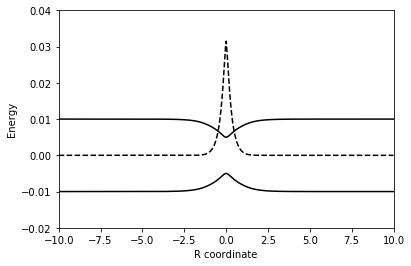

In [689]:
xmin,xmax = -10,10;
x = np.linspace(xmin,xmax,1000);
tens = model.V(x);
eigA = np.zeros(len(x));
eigB = np.zeros(len(x));
for i in range(len(x)):
  eigA[i] = np.linalg.eigh(tens[:,:,i])[0][0]
  eigB[i] = np.linalg.eigh(tens[:,:,i])[0][1]

fig = plt.figure()
# plot diabatic PES
# plt.plot(x, model.V(x)[1,1], 'k-')
# plt.plot(x, model.dV(x)[0,0], 'k-');
# plot adiabatic PES
plt.plot(x, eigA, 'k-');
plt.plot(x, eigB, 'k-');
plt.plot(x, 0.02*model.d_12(x)[1,0], 'k--');
plt.ylim([-0.02,0.04]);
plt.ylabel("Energy");
plt.xlim([-10,10]);
plt.xlabel("R coordinate");

Now that we have the model, can follow step 1:

**Initial conditions for the first trajectory are assigned consistent with the experiment to be simulated. This includes assignment of the initial positions and momenta of all of the atoms, and assignment of the initial electronic density matrix elements $a_{kj}$ Typically, only a single electronic
state $k$ will be populated initially, i.e., $a_{lj} = \delta_{lk} \delta_{jk}$ There is no reason, however, why the initial conditions could not correspond to a coherent or incoherent mixture of electronic
states.**

In [0]:
# Initial momentum
p0 = 1
# Initial position
x0 = -9
# Initial electronic density matrix: adiabatic population all in state 1 (0 with Python indexing)
a0 = [[1,0],[0,0]]
# Timestep (a.u.)
dt = 0.5
# Mass (a.u.)
mass = 2e3

Integration of the classical degrees of freedom via the velocity verlet algorithm, as described in step 2.

**The classical mechanical equations of motion for the atoms on the current potential energy surface $V_{kk}$ are integrated for a small time interval $\Delta t$. Equations (8) for the electronic amplitudes or Eq. (11) for the density matrix elements are integrated along this trajectory. The time interval $\Delta t$ may be a single numerical integration time step, or a few steps, so long as it is sufficiently short that the electronic probabilities change only slightly during any interval.**

Eq. (8):

$i\hbar\dot{c}_{k} = \sum_{j} c_{j}\left(V_{kj}-i\hbar \bf{\dot{R}\!\cdot\! d_{kj}}\right)$

Eq. (11):

$i\hbar\dot{a}_{kj} = \sum_{l} \left(a_{lj}\left[V_{kl}-i\hbar \bf{\dot{R}\!\cdot\! d_{kl}}\right]-a_{kl}\left[V_{lj}-i\hbar \bf{\dot{R}\!\cdot\! d_{lj}}\right]\right)$

where
$a_{kj} = c_k^*c_j $.

In [0]:
# Classical propagation of the nuclear DoF with a standard velocity verlet algorithm
def vv(x0ld,p0ld,dt,state,mass):
  v0ld = p0ld/mass
  a0ld = - model.dV(x0ld)[state,state]/mass
  xnew = x0ld + v0ld*dt + 0.5*a0ld*dt*dt
  anew = - model.dV(xnew)[state,state]/mass
  pnew = p0ld + 0.5*(a0ld+anew)*dt*mass
  return xnew, pnew

# Kinetic Energy
def ke(momentum,mass):
  vel = momentum/mass
  return 0.5*vel*vel*mass

# Potential Energy
def pe(position,state):
  return model.V(position)[state,state]

# Total Energy
def te(position,momentum,state,mass):
  return pe(position,state)+ke(momentum,mass)

# Propagation of the density matrix elements a_ij
def dm(a0):
  
  return anew

In [0]:
traj_x = [(-3,5),(-2,1),(4,6),(-4,2),(4,5)];
traj_x[1][1];
time = 0
list = []
state = 0
while time < 300:
  traj_x = [vv(x[0],x[1],dt=10,state=state,mass=mass) for x in traj_x]
  list.append(traj_x)
  time += dt

In [0]:
trajectoryApos = []
trajectoryAmom = []
Kenergy = []
Penergy = []
Tenergy = []
for i in range(600):
  trajectoryApos.append(list[i][3][0])
  trajectoryAmom.append(list[i][3][1])
  Kenergy.append(ke(trajectoryAmom[i],mass=mass))
  Penergy.append(pe(trajectoryApos[i],state=state))
  Tenergy.append(te(trajectoryApos[i],trajectoryAmom[i],state=state,mass=mass))



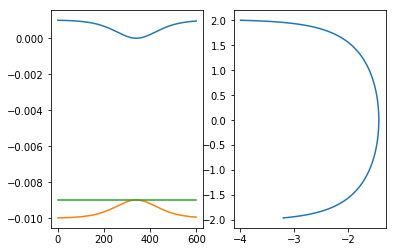

In [740]:
fig, (ax1, ax2) = plt.subplots(1, 2);
ax1.plot(Kenergy);
ax1.plot(Penergy);
ax1.plot(Tenergy);
ax2.plot(trajectoryApos,trajectoryAmom);

In [764]:
eig,eiv = np.linalg.eigh(model.V(0.3))
eiv
#eiv[1]
#eiv[0,1]
a11=np.dot(np.conj(eig[0]),eig[0])
a12=np.dot(np.conj(eig[0]),eig[1])
a21=np.dot(np.conj(eig[1]),eig[0])
a22=np.dot(np.conj(eig[1]),eig[1])
a = [[a11,a12],[a21,a22]]
eig

array([-0.005951,  0.005951])

In [756]:
vect = np.random.rand(1,8)
print(vect)
for i in vect:
  print(model.V(i))


[[0.43799124 0.27469341 0.06809956 0.28289414 0.30778296 0.51592878
  0.0034994  0.77261031]]
[[[ 5.03804849e-03  3.55647576e-03  1.03233079e-03  3.64047006e-03
    3.88874373e-03  5.61977956e-03  5.58339303e-05  7.09507200e-03]
  [ 4.12720981e-03  4.63660047e-03  4.97686594e-03  4.61544744e-03
    4.54809090e-03  3.83149632e-03  4.99993877e-03  2.75250451e-03]]

 [[ 4.12720981e-03  4.63660047e-03  4.97686594e-03  4.61544744e-03
    4.54809090e-03  3.83149632e-03  4.99993877e-03  2.75250451e-03]
  [-5.03804849e-03 -3.55647576e-03 -1.03233079e-03 -3.64047006e-03
   -3.88874373e-03 -5.61977956e-03 -5.58339303e-05 -7.09507200e-03]]]


In [0]:
# Generate initial conditions
numTraj = 100
dT = 1 # timestep
initP = 0
initQ = 1
mass = 2000

In [0]:
# Classical nuclei velocity verlet integrator
acceleration = force / mass
def velocity_verlet(old_position, old_velocity, timestep,acceleration):
  new_position = old_position + old_velocity * timestep
  new_velocity = old_velocity + acceleration * timestep
  return new_position, new_velocity

0.11418160778148789

In [0]:
# Calculate hopping probability & random number generator
def surface_hop():
  random_number = np.random.rand()
  test
  if random_number < test:
    bool = True
  elif random_number > test:
    bool = False
  else:
    print("Error")
  return bool

Trying to run CUDA on Colab GPUs

In [0]:
import torch

In [0]:
torch.cuda.memory_allocated()

0

In [0]:
a = torch.rand(128,600).cuda()

In [0]:
b = np.random.rand(128,600)

In [0]:
def func(obj):
  out = obj**2
  return out

In [0]:
%timeit func(a)

The slowest run took 1600.61 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 10.1 µs per loop


In [0]:
%timeit func(b)

The slowest run took 13.36 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 86.1 µs per loop


In [0]:
# class DAXModel:
#  def __init__(self):
#    self.representation = representation # Adiabatic or Diabatic